# Scarce evidence for non-random correlation between gene- and comorbidity-based disease networks

In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools as itt
import json
import matplotlib.pyplot as plt
import graph_tool as gt
import graph_tool.stats as gts
from pathlib import Path
import numpy as np
import scipy.stats as sps

In [9]:
a = np.random.random(1000)
b = np.random.random(1000) - 0.05
np.fabs(a - b).sum()

344.17484556092484

In [113]:
print(sps.wilcoxon(x=a, y=b, alternative="two-sided"))
print(sps.wilcoxon(x=a, y=b, alternative="less"))

WilcoxonResult(statistic=216666.0, pvalue=0.00023674707760724655)
WilcoxonResult(statistic=216666.0, pvalue=0.00011837353880362327)


In [63]:
def adjust_titles(fig, width=60):
    with open('data/icd10_chapter_to_description.json') as fp:
        chapter_to_description = json.load(fp)
    for axis in fig.axes.flatten():
        chapter = axis.get_title().split(' = ')[1]
        axis.set_title('')
        if chapter == 'Global':
            title = chapter
        else:
            title = f'{chapter}: {chapter_to_description[chapter]}'
        if len(title) > width:
            words = title.split(' ')
            title=''
            length_line = 0
            for word in words:
                if title == '':
                    title = word
                    length_line = len(word)
                elif length_line + len(word) + 1 <= 50:
                    title = f'{title} {word}'
                    length_line += 1 + len(word)
                else:
                    title = f"{title}\n{word}"
                    length_line = len(word)  
        axis.set_title(title, loc='left')
    fig.fig.tight_layout()

In [79]:
def add_significance_line(fig, significance_level=0.05):
    for axis in fig.axes.flatten():
        axis.axhline(-np.log10(significance_level))

## Methods

### Gene-based diseasome

- Constructed by Sepi based on DisGeNET and OMIM.
- Undirected edges are weighted with Jaccard index:

$$w_{ij}=J(d_id_j)=\frac{|\mathit{genes}(d_i)\cap\mathit{genes}(d_j)|}{|\mathit{genes}(d_i)\cup\mathit{genes}(d_j)|}$$

### Comorbidity-based diseasome

- Taken from [Siggaard et al. (2020)](https://www.nature.com/articles/s41467-020-18682-4) (Supplementary Data 1).
- Directed edges are weighted with customized relative risk: $$w_{i,j}=\mathit{RR}(d_i,d_j)=\frac{10000\cdot|\{s\in P_i\mid\text{patient $s$ has disease $d_j$}\}|}{\sum_{s\in P_i}|\{s^\prime\in M_s\mid\text{patient $s^\prime$ has disease $d_j$}\}|}\text{, where}$$
- $P_i$ is set of all patients with disease $d_i$.
- For all $s\in P_i$, $M_s$ is matched set of $10000$ patients.
- To derive an undirected version, we set $w_{ij}=\mathit{RR}(d_id_j)=(\mathit{RR}(d_i,d_j)+\mathit{RR}(d_j,d_i))/2$ whenever both the edge $(d_i,d_j)$ and the edge $(d_j,d_i)$ exist in the network.

### Network integration

- Discard all diseases that are contained in only one of the two networks.
- $\Longrightarrow$ Keep set $D$ of diseases contained in both.
- Compute normalized edge weights as follows: $$\hat{w}_{ij}=\frac{w_{ij}}{\max_{ij\in E}w_{ij}}$$
- Compute normalized edge ranks as follows: $$\hat{r}_{ij}=\frac{|\{d_{i^\prime}d_{j^\prime}\in E\mid w_{i^\prime j^\prime}<w_{ij}\}|}{|E|}$$
- $\Longrightarrow$ Both the normalized weights and the normalized weights are comparable.

### Compare networks via graph edit distance

- Let $G^g=(D,E^g)$ be gene-based diseasome and $G^c=(D,E^c)$be comorbidity-based diseasome.
- Compare diseasomes via graph edit distance (GED) using, respectively, topology only, normalized weights, and normalized ranks: 
$$
\begin{align}
\mathrm{GED}(G^g,H^g)&=\overbrace{\sum_{d_id_j\in E^g\cap E^h}|s^g_{ij}-s^c_{ij}|+\sum_{d_id_j\in E^g\setminus E^h}1 + s^g_{ij}+\sum_{d_id_j\in E^h\setminus E^g}1 + s^h_{ij}}^{\text{Global distance between the diseasomes $G^g$ and $G^c$.}}\\
&=\frac{1}{2}\cdot\sum_{d_i\in D}\underbrace{\sum_{d_j\in N^g_i\cap N^h_i}|s^g_{ij}-s^c_{ij}|+\sum_{d_j\in N^g_i\setminus E^h_i}1 + s^g_{ij}+\sum_{d_j\in E^h_i\setminus E^g_i}1 + s^h_{ij}}_{\text{Local distance $\mathrm{GED}_i(G^g,H^g)$ for disease $D_i$, given the diseasomes $G^g$ and $G^c$.}}
\end{align}
$$
- Topology only: $s_{ij}=0$.
- Normalized weights: $s_{ij}=\hat{w}_{ij}$.
- Normalized ranks: $s_{ij}=\hat{r}_{ij}$.

### Permutation tests

- Compute distances between $G^g$ and $G^c$.
- Compute distances for $n$ pairs $(\tilde{G}^g_k,\tilde{G}^c_k)_{k=1}^n$ of random networks with preserved node degrees, generated with [graph_tool.generation.random_rewire()](https://graph-tool.skewed.de/static/doc/generation.html#graph_tool.generation.random_rewire).
- Compute empirical $p$-values for the global networks and the individual diseases:
- Global empirical $p$-value for entire networks: $$\text{$p$-value}=\frac{|\{k\in\{1,\ldots,n\}\mid\mathrm{GED}(\tilde{G}^g_k,\tilde{G}^c_k)\leq\mathrm{GED}(G^g,H^g)\}|}{n+1}$$
- Local empirical $p$-value for disease $D_i$: $$\text{$p$-value}=\frac{|\{k\in\{1,\ldots,n\}\mid\mathrm{GED}_i(\tilde{G}^g_k,\tilde{G}^c_k)\leq\mathrm{GED}_i(G^g,H^g)\}|}{n+1}$$
- Compute $p$-values for batches of diseases (all diseases, ICD-10 chapters, ICD-10 ranges, commROCG genes):
  - Using the **one-sided Mann-Whitney $U$-test**, where one sample contains local distances for the original network and the other one contains local distances for the permuted networks.
  - Using the **one-sided Wilcoxon signed-rank test**, where one sample contains local distances for the original network and the other one contains the means of the local distances for the permuted networks across all permutations.

## Results

- Ran permutation tests as described above with $n=1000$ permutations.

### Network statistics

#### Numbers of nodes and edges

In [95]:
ji_graph = gt.load_graph('data/normalized_jaccard_index_diseasome.graphml')
rr_graph = gt.load_graph('data/normalized_relative_risk_diseasome.graphml')
nums_nodes = [ji_graph.num_vertices(), rr_graph.num_vertices()]
nums_edges = [ji_graph.num_edges(), rr_graph.num_edges()]
network_types = ['gene-based', 'comorbidity-based']
network_stats = pd.DataFrame(data={'type': network_types, 'num_nodes': nums_nodes, 'num_edges': nums_edges})
network_stats

,type,num_nodes,num_edges
0,gene-based,1006,38692
1,comorbidity-based,1006,9017


#### Degree distribution for gene-based diseasome

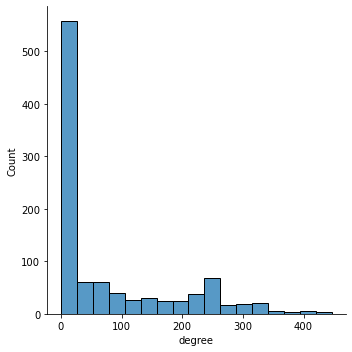

In [106]:
ji_degs = ji_graph.get_total_degrees([node for node in ji_graph.vertices()])
fig = sns.displot(data=pd.DataFrame({'degree': ji_degs}), x='degree')

#### Degree distribution for comorbidity-based diseasome

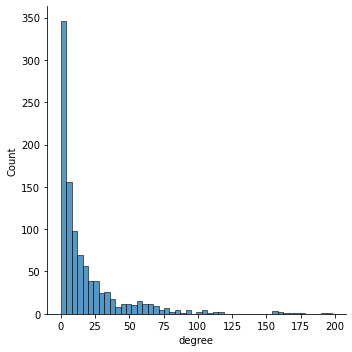

In [107]:
rr_degs = rr_graph.get_total_degrees([node for node in rr_graph.vertices()])
sns.displot(data=pd.DataFrame({'degree': rr_degs}), x='degree')

#### Normalized Jaccard index and rank distributions for gene-based diseasome

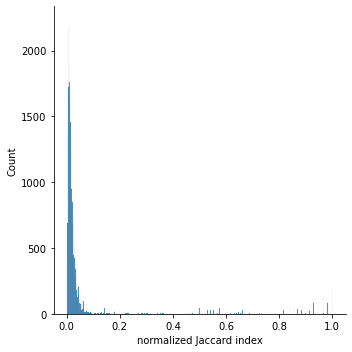

In [119]:
ji_norm_scores = [ji_graph.edge_properties['JI-NORM'][edge] for edge in ji_graph.edges()]
sns.displot(data=pd.DataFrame({'normalized Jaccard index': ji_norm_scores}), x='normalized Jaccard index')

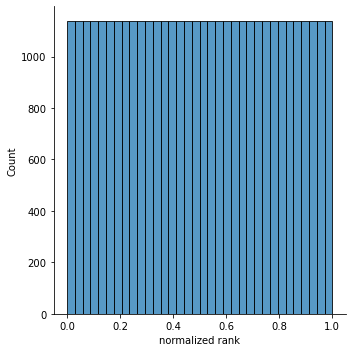

In [117]:
ji_norm_ranks = [ji_graph.edge_properties['JI-NORM-RANK'][edge] for edge in ji_graph.edges()]
sns.displot(data=pd.DataFrame({'normalized rank': ji_norm_ranks}), x='normalized rank')

#### Normalized relative risk and rank distribution for comorbidity-based diseasome

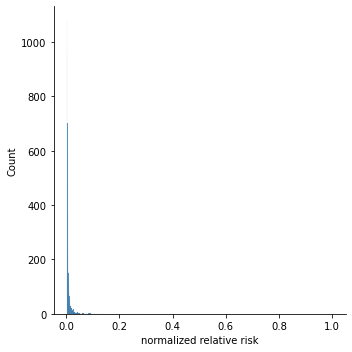

In [120]:
rr_norm_scores = [rr_graph.edge_properties['RR-NORM'][edge] for edge in rr_graph.edges()]
sns.displot(data=pd.DataFrame({'normalized relative risk': rr_norm_scores}), x='normalized relative risk')

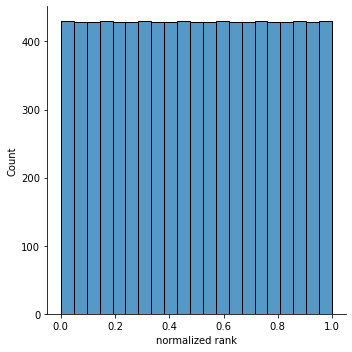

In [121]:
rr_norm_ranks = [rr_graph.edge_properties['RR-NORM-RANK'][edge] for edge in rr_graph.edges()]
sns.displot(data=pd.DataFrame({'normalized rank': rr_norm_ranks}), x='normalized rank')

### Results for global distances

#### GEDs for original and permuted networks

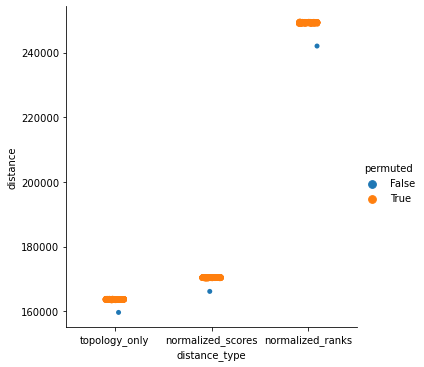

In [4]:
results = pd.read_csv('results/EST_permutation_results.csv')
sns.catplot(data=results[results['comparison'] == 'global'], x='distance_type', y='distance', hue='permuted')

In [6]:
index = [(comp, dist_type) for comp in set(results['comparison']) for dist_type in set(results['distance_type'])]
index

[('J38', 'topology_only'),
 ('J38', 'normalized_ranks'),
 ('J38', 'normalized_scores'),
 ('J15', 'topology_only'),
 ('J15', 'normalized_ranks'),
 ('J15', 'normalized_scores'),
 ('F15', 'topology_only'),
 ('F15', 'normalized_ranks'),
 ('F15', 'normalized_scores'),
 ('C22', 'topology_only'),
 ('C22', 'normalized_ranks'),
 ('C22', 'normalized_scores'),
 ('C47', 'topology_only'),
 ('C47', 'normalized_ranks'),
 ('C47', 'normalized_scores'),
 ('H93', 'topology_only'),
 ('H93', 'normalized_ranks'),
 ('H93', 'normalized_scores'),
 ('L22', 'topology_only'),
 ('L22', 'normalized_ranks'),
 ('L22', 'normalized_scores'),
 ('D45', 'topology_only'),
 ('D45', 'normalized_ranks'),
 ('D45', 'normalized_scores'),
 ('A87', 'topology_only'),
 ('A87', 'normalized_ranks'),
 ('A87', 'normalized_scores'),
 ('G03', 'topology_only'),
 ('G03', 'normalized_ranks'),
 ('G03', 'normalized_scores'),
 ('Q66', 'topology_only'),
 ('Q66', 'normalized_ranks'),
 ('Q66', 'normalized_scores'),
 ('L63', 'topology_only'),
 ('L6

#### Empirical p-values for global distances

In [13]:
global_empirical_p_values = pd.read_csv('results/EST_global_empirical_p_values.csv')
global_empirical_p_values

,distance_type,p_value
0,topology_only,0.000999
1,normalized_ranks,0.000999
2,normalized_scores,0.000999


- **$\Longrightarrow$ Globally, there seems to be a non-random correlation.**

### Results for local, disease-specific distances

#### Distributions of local distances for original and permuted networks

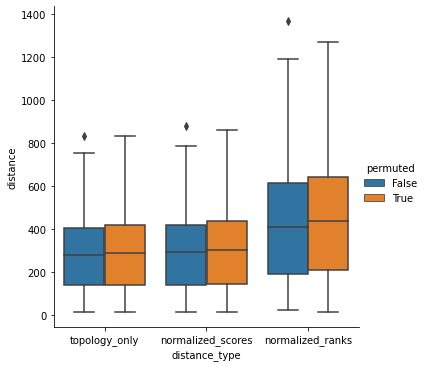

In [4]:
sns.catplot(data=results[results['comparison'] != 'global'], x='distance_type', y='distance', hue='permuted', kind='box')

#### MWU p-values for local distances

In [6]:
mwu_global_p_values = pd.read_csv('results/EST_global_mwu_p_values.csv')
mwu_global_p_values 

,distance_type,p_value
0,topology_only,0.089569
1,normalized_ranks,0.014808
2,normalized_scores,0.070549


#### Wilcoxon p-values for local distances

- $\Longrightarrow$ When comparing disease-specific instead of network-wide distances, the differences between original and permuted networks are no longer significant.
- **$\Longrightarrow$ Signal seems to be so weak that it vanishes when zooming-in to the disease level.** 

#### Local distances for ICD-10 chapters

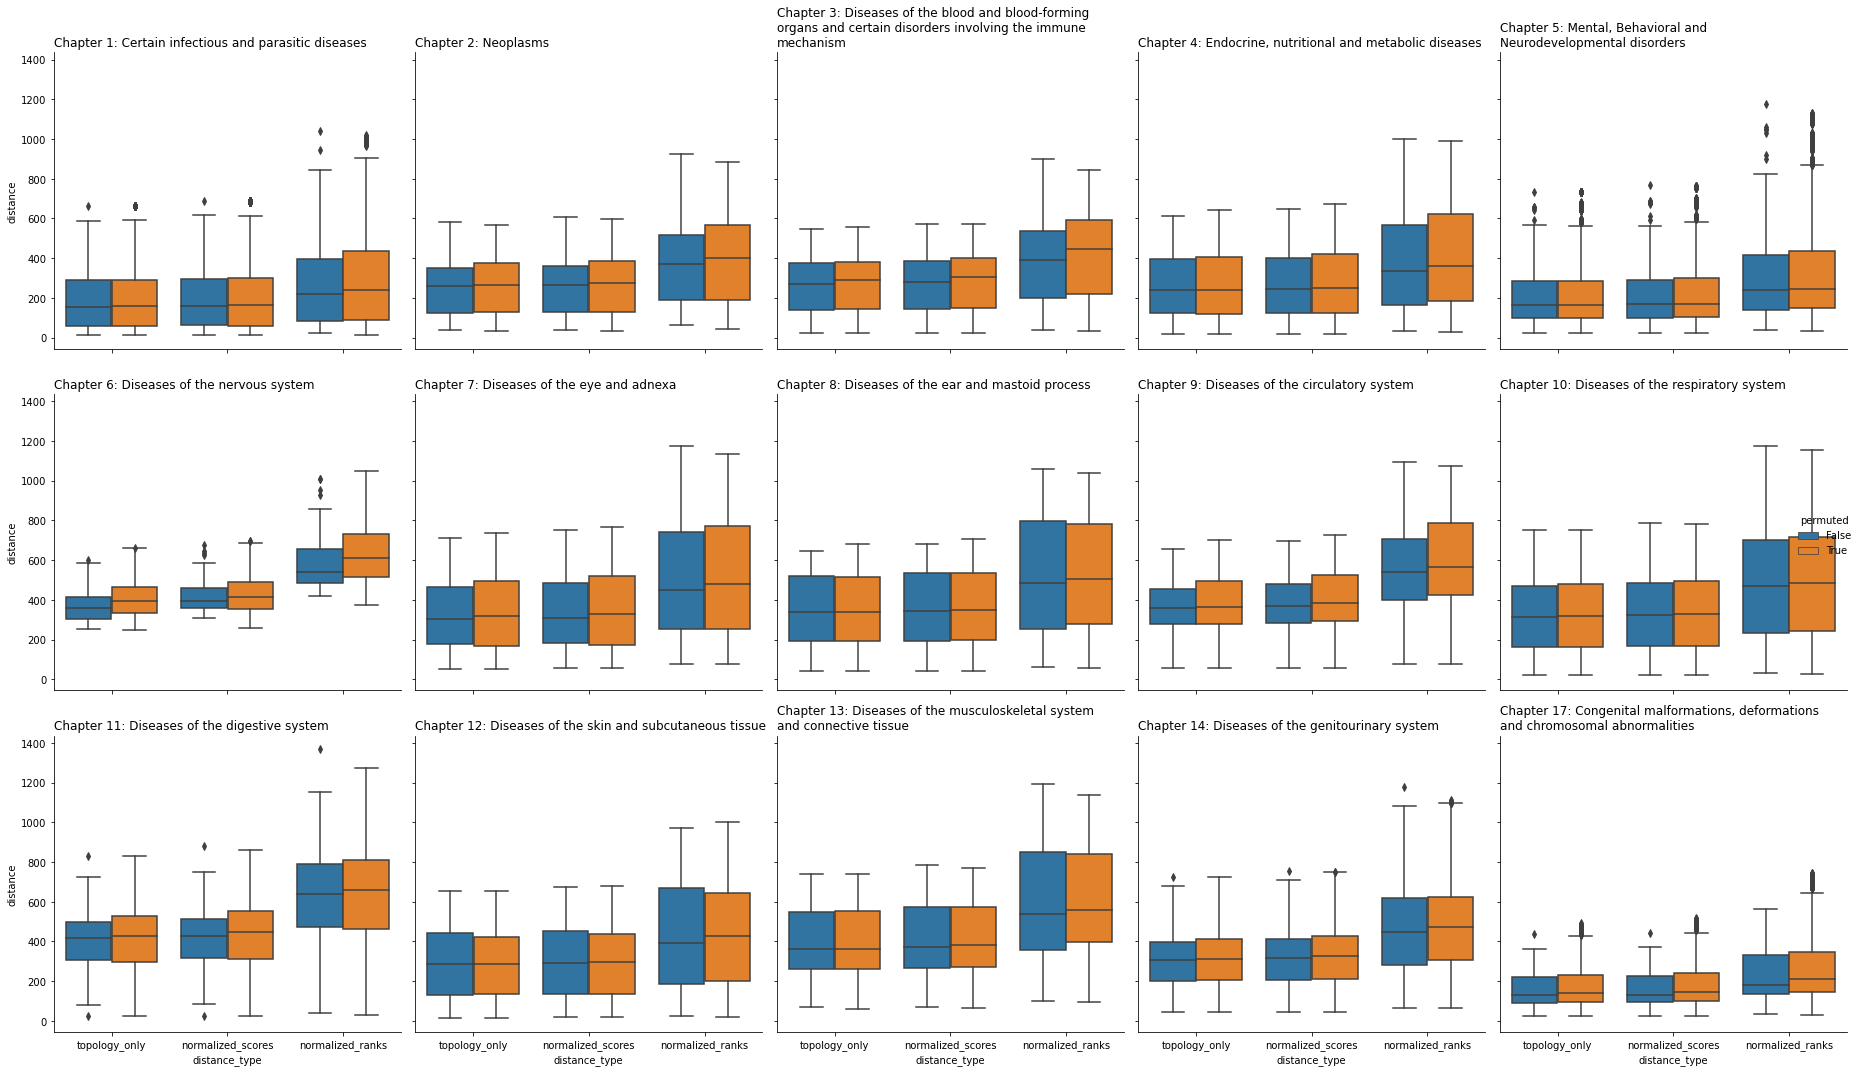

In [65]:
local = results[results['chapter'] != 'Global']
fig = sns.catplot(data=local, x='distance_type', y='distance', col='chapter', hue='permuted', col_wrap=5, kind='box')
adjust_titles(fig, 60)

In [97]:
print(local.min())

permuted                    False
comparison                    A00
distance                     12.0
distance_type    normalized_ranks
chapter                 Chapter 1
range                     Range 1
dtype: object


#### MWU p-values for ICD-10 chapters

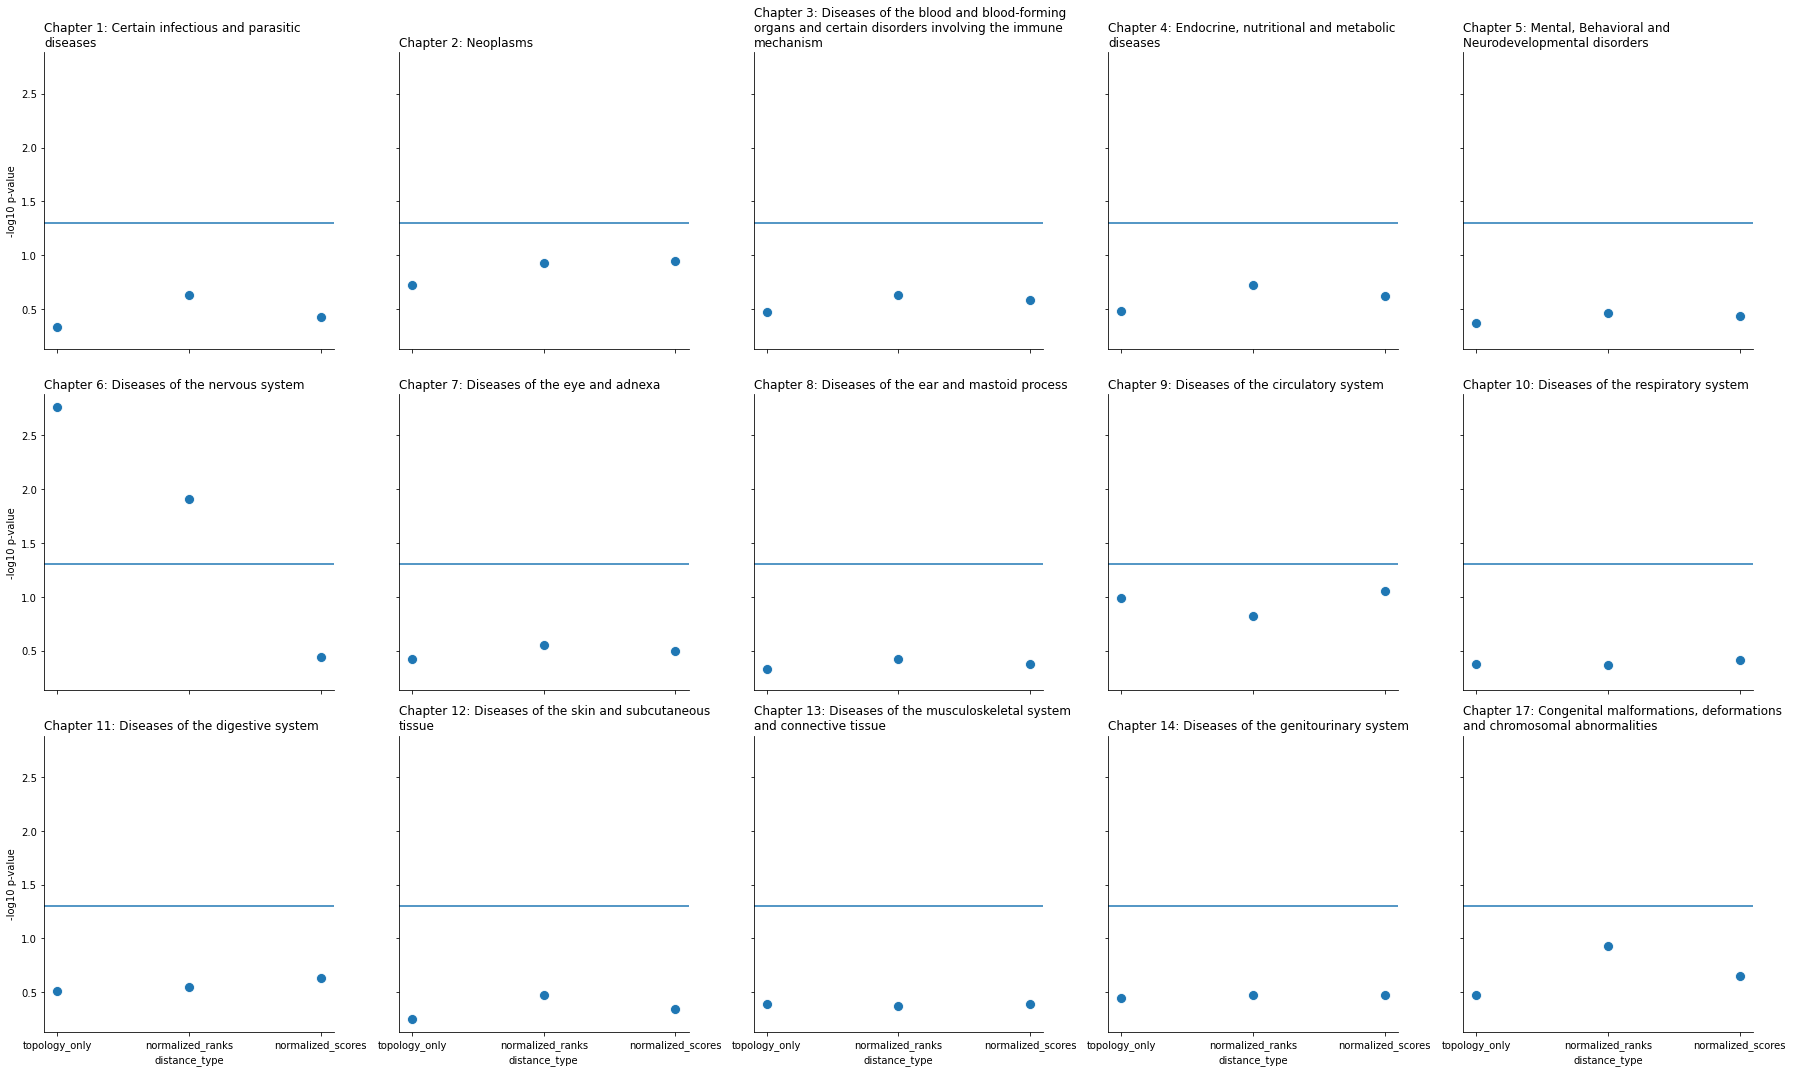

In [80]:
chapters = [f'Chapter {i}' for i in list(range(1,15)) + [17]]
mwu_chapter_p_values = pd.read_csv('results/EST_chapter_mwu_p_values.csv')
mwu_chapter_p_values['-log10 p-value'] = mwu_chapter_p_values['p_value'].apply(lambda x: -np.log10(x))
fig = sns.relplot(data=mwu_chapter_p_values, x='distance_type', y='-log10 p-value', col='chapter', col_order=chapters, col_wrap=5, s=100)
add_significance_line(fig)
adjust_titles(fig)

#### Wilcoxon p-values for ICD-10 chapters

- $\Longrightarrow$ Only two MWU tests reached significance, **even without multiple testing correction**.

#### MWU p-values for ICD-10 ranges

In [9]:
with open('data/icd10_range_to_description.json') as fp:
    range_to_description = json.load(fp)

In [90]:
mwu_p_values_ranges = pd.read_csv('results/EST_range_mwu_p_values.csv')
significant_ranges = mwu_p_values_ranges[mwu_p_values_ranges['p_value'] < 0.05].reset_index(drop=True)
significant_ranges['range'] = significant_ranges['range'].apply(lambda x: f'{x}: {range_to_description[x]}')
significant_ranges

,range,distance_type,p_value,adjusted_p_value
0,Range 136: Systemic connective tissue disorders,topology_only,0.037837,0.974376
1,Range 136: Systemic connective tissue disorders,normalized_ranks,0.016576,0.805640
2,Range 136: Systemic connective tissue disorders,normalized_scores,0.025386,0.917442
3,Range 74: Polyneuropathies and other disorders...,topology_only,0.048290,0.989978
4,Range 74: Polyneuropathies and other disorders...,normalized_ranks,0.022622,0.888830
5,Range 77: Other disorders of the nervous system,topology_only,0.005630,0.421686
6,Range 77: Other disorders of the nervous system,normalized_ranks,0.015769,0.792697
7,Range 49: Diabetes mellitus,topology_only,0.047238,0.989418
8,Range 49: Diabetes mellitus,normalized_scores,0.045166,0.988168
9,Range 67: Inflammatory diseases of the central...,topology_only,0.002954,0.251640


- **$\Longrightarrow$ Without multiple testing correction**: Only four MWU and Wilcoxon tests reached significance.
- **$\Longrightarrow$ With multiple testing correction**: Not a single test reached significance.

#### Numbers of diseases with and without empirical p-values < 0.001 (divided by ICD-10 chapter)

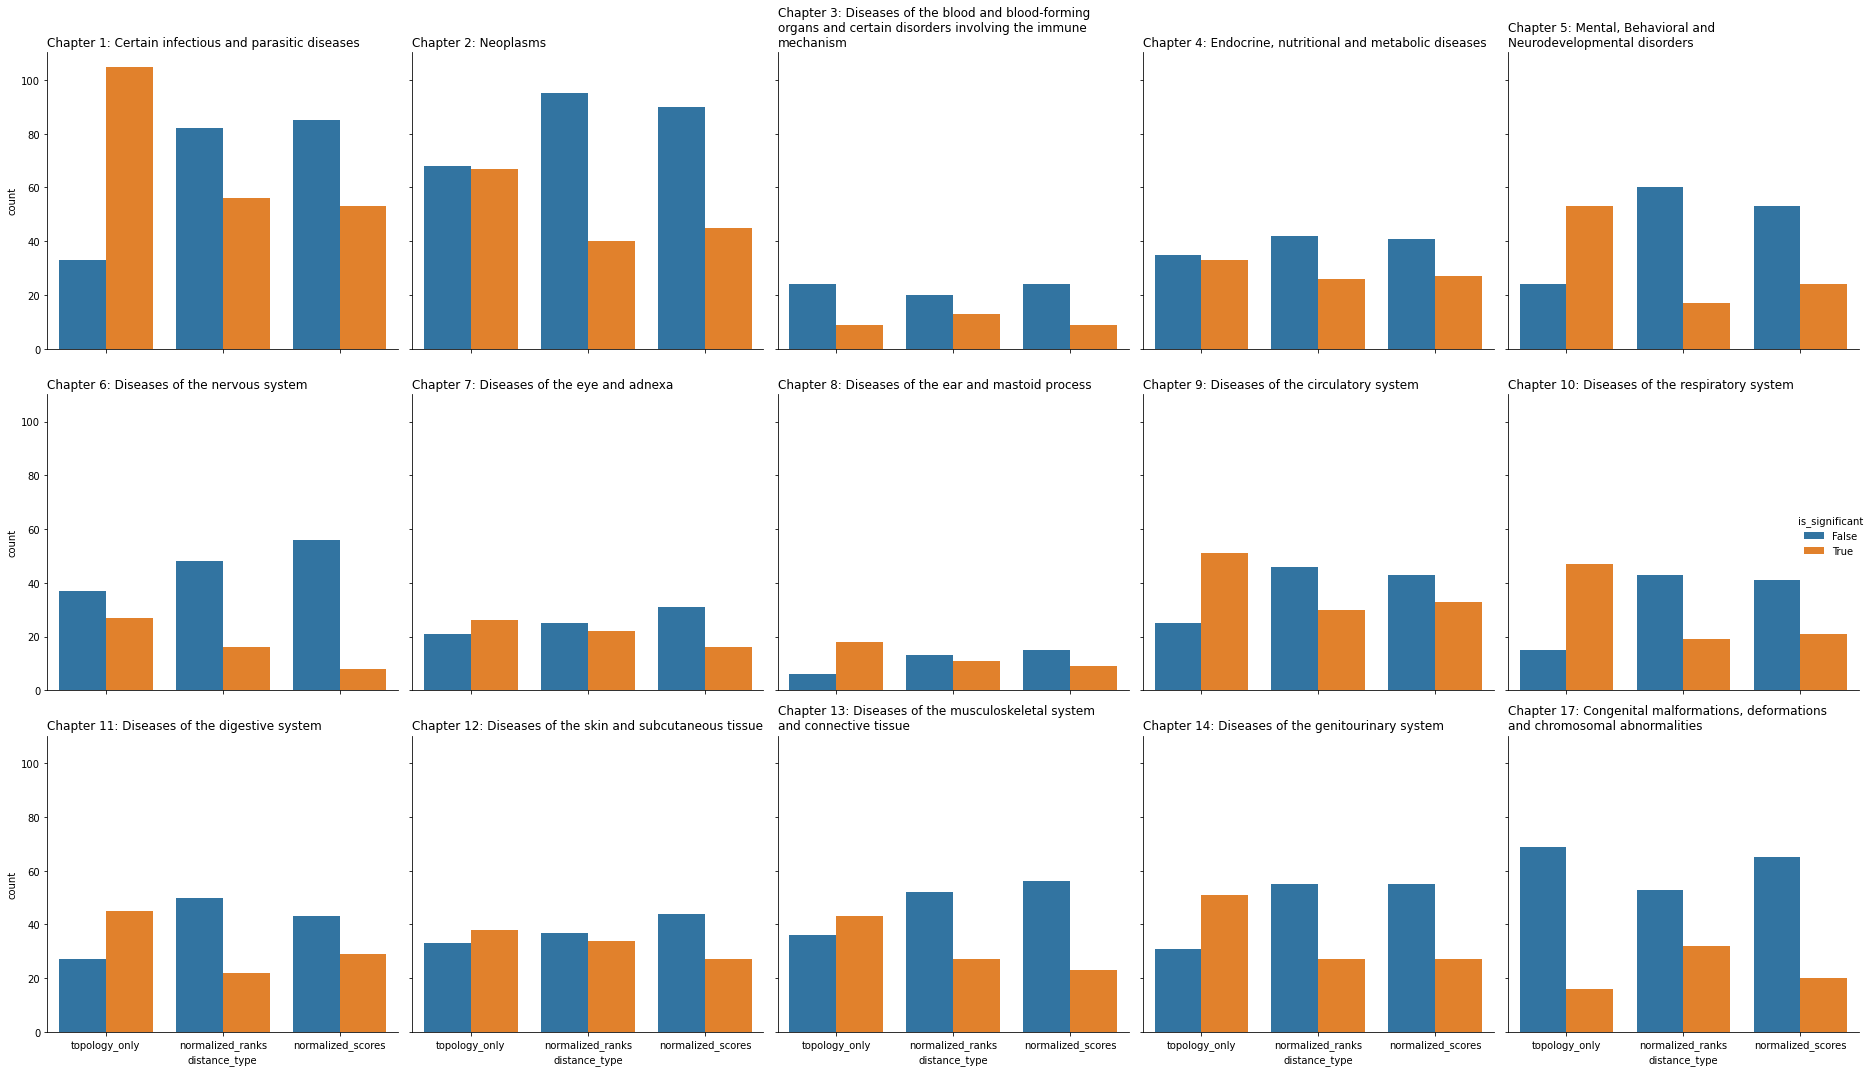

In [96]:
empirical_p_values = pd.read_csv('results/EST_disease_empirical_p_values.csv')
with open('data/icd10_code_to_description.json') as fp:
    code_to_description = json.load(fp)
empirical_p_values['is_significant'] = empirical_p_values['p_value'] < 0.001
fig = sns.catplot(data=empirical_p_values, x='distance_type', col='chapter', col_order=chapters, col_wrap=5, kind='count', hue='is_significant')
adjust_titles(fig, 60)
#display(empirical_p_values[empirical_p_values['is_significant'] & (empirical_p_values['chapter'] == 'Chapter 1')])

#### Local distances for commROCG diseases

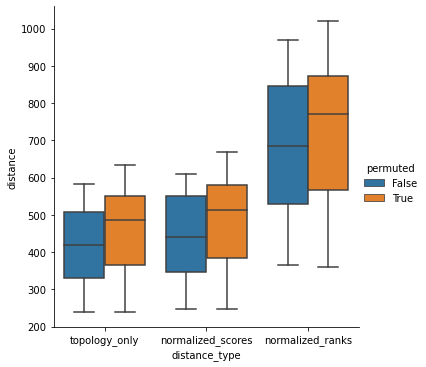

In [68]:
commrocg = set(pd.read_csv('data/commrocg.tsv', sep='\t')['Code'])
fig = sns.catplot(data=results[results['comparison'].isin(commrocg)], x='distance_type', y='distance', hue='permuted', kind='box')

#### MWU p-values for commROCG diseases

In [15]:
mwu_commrocg_p_values = pd.read_csv('results/EST_commrocg_mwu_p_values.csv')
mwu_commrocg_p_values

,distance_type,p_value
0,topology_only,0.017460
1,normalized_ranks,0.110313
2,normalized_scores,0.024983


#### Numbers of commROCG diseases with empirical p-value < 0.001

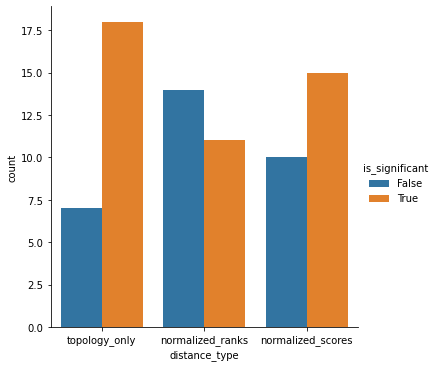

In [87]:
empirical_p_values_commrocg = empirical_p_values[empirical_p_values['disease'].isin(commrocg)].reset_index(drop=True)
fig = sns.catplot(data=empirical_p_values_commrocg, x='distance_type', kind='count', hue='is_significant')

#### Local distances for monogentic diseases

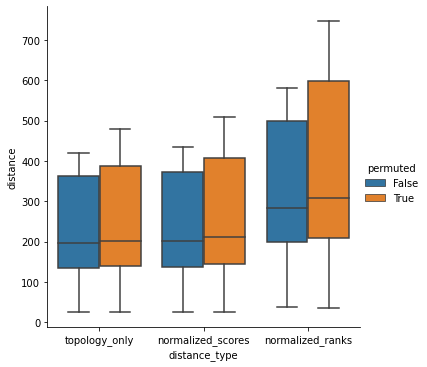

In [16]:
monogenetic = set(pd.read_csv('data/monogenetic.tsv', sep='\t')['Code'])
sns.catplot(data=results[results['comparison'].isin(monogenetic)], x='distance_type', y='distance', hue='permuted', kind='box')

#### MWU p-values for monogenetic diseases

In [17]:
mwu_monogenetic_p_values = pd.read_csv('results/EST_monogenetic_mwu_p_values.csv')
mwu_monogenetic_p_values

,distance_type,p_value
0,topology_only,0.188763
1,normalized_ranks,0.077804
2,normalized_scores,0.123704


#### Numbers of monogenetic diseases with empirical p-value < 0.001

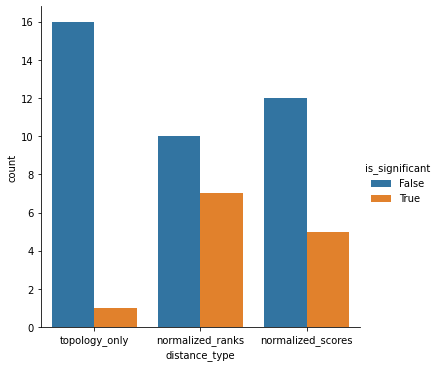

In [88]:
empirical_p_values_monogenetic = empirical_p_values[empirical_p_values['disease'].isin(monogenetic)].reset_index(drop=True)
fig = sns.catplot(data=empirical_p_values_monogenetic, x='distance_type', kind='count', hue='is_significant')

**$\Longrightarrow$ Again, nothing is significant.**

## Conclusions

- Globally, there seems to be a non-random correlation between the two diseasomes.
- But the evidence for this claim is very weak, and as soon as we zoom-in and increase the resolution, the results no longer support it (I did not even correct for multiple testing when computing the disease-specific empirical $p$-values). 
- **$\Longrightarrow$ The local neighborhoods of individual diseases are not significantly more similar for the two diseasomes than for random networks with the same node degrees.**
- I see three possible explanations:
  - Poor quality of gene-based diseasome.
  - Poor quality of comorbidity-based diseasome.
  - **Poor disease ontology**.
  - **Quality gets lost during disease ID mapping**.

## Next steps

- Re-run the tests with $n=100000$ permutations such that we can compute meaningful adjusted $p$-values for the individual diseases.
- Enough for a short paper?
- If so, where shall we submit? Maybe Scientific Reports or NPJ Systems Biology and Applications?
- If not, what shall we add?

In [13]:
results[results['comparison'] == 'G35']

,permuted,comparison,distance,distance_type,chapter,range
331,False,G35,326.000000,topology_only,Chapter 6,Range 71
1338,False,G35,359.314092,normalized_scores,Chapter 6,Range 71
2345,False,G35,512.489462,normalized_ranks,Chapter 6,Range 71
3352,True,G35,316.000000,topology_only,Chapter 6,Range 71
4359,True,G35,331.851222,normalized_scores,Chapter 6,Range 71
...,...,...,...,...,...,...
3019317,True,G35,339.679114,normalized_scores,Chapter 6,Range 71
3020324,True,G35,486.157922,normalized_ranks,Chapter 6,Range 71
3021331,True,G35,314.000000,topology_only,Chapter 6,Range 71
3022338,True,G35,326.422153,normalized_scores,Chapter 6,Range 71
